In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import sys 
sys.path.append('..')
from codeprint import RawCode

In [3]:
from rrt import *

# Rapidly Exploring Tree Star (RRT*)

### Define Node Class
* variables : position, parent(previous node), cost
* methods : 
    * \- (sub) : calculate euclidean distance
    * repr : print node information
    * show : visualize node position

In [4]:
code = RawCode('rrt.py')
code.show('Node')

class Node():
    def __init__(self, position, parent=None):
        self.position = np.array(position)
        self.parent = parent
        self.cost = 0 # for rrt*

    def __sub__(self, other):
        return LA.norm(self.position - other.position)
    
    def __repr__(self):
        return 'pos:{0}'.format(self.position)
    
    def show(self, **kwargs):
        plt.gca().scatter(self.position[0], self.position[1], **kwargs)
        plt.xlim([0,10])
        plt.ylim([0,10])


### Define RRT* Algorithm Class
* variables : 
    * new_node_dist : step length for new node 
    * smpl_area : map area for RRT
    * obstacles : circular obstacles informations
* methods : 
    * get_rnd_node : select random point(node) in smpl_area
    * is_goal : goal node detection using euclidean distance
    * is_collision : collision detection using euclidean distance
    * is_in_area : check if node is in area
    * find_nearest_node : find nearest node in tree
    * fine_neighbor_nodes : find neighbor node of new_node by distance

In [5]:
code = RawCode('rrt.py')
code.show('RRT')

class RRT(RRTAlg):
    def show(self):
        self.plot_tree()
        self.plot_obstacles()
        self.start.show(color='r', label='start')
        self.end.show(color='b', label='goal')
        self.plot_final_path()
        
    def plot_tree(self):
        ax = plt.gca()
        for node in self.tree:
            if node.parent:
                pts = np.array([node.position, node.parent.position])
                ax.plot(*pts.T, color='k')
        return ax
    
    def plot_obstacles(self):
        ax = plt.gca()
        for obs in self.obstacles:
            c = mpatches.Circle(obs[:2], obs[2], fc='k')
            im = ax.add_artist(c)
        return im
    
    def plot_final_path(self):
        if not 'goal_node' in dir(self):
            return False
        
        ax = plt.gca()
        temp_node = self.goal_node
        while temp_node.parent:
            pts = np.array([temp_node.position, temp_node.parent.position])
            im = ax.plot(*pts.T, color='r')
        

In [6]:
code = RawCode('rrt.py')
code.show('RRTstarAlg')

class RRTstarAlg(RRTAlg):

    def find_neighbor_nodes(self, new_node, dist=1):
        neighbor_list = []
        for i,node in enumerate(self.tree):
            if (new_node - node) < dist:
                neighbor_list.append((i, node))
        return neighbor_list


### RRT Class : RRT Algorithm + Visualization

In [7]:
code = RawCode('rrt.py')
code.show('RRTstar')

class RRTstar(RRTstarAlg):
    
    def show(self):
        self.plot_tree()
        self.plot_obstacles()
        self.start.show(color='r', label='start')
        self.end.show(color='b', label='goal')
        self.plot_final_path()
        
    def plot_tree(self):
        ax = plt.gca()
        for node in self.tree:
            if node.parent:
                pts = np.array([node.position, node.parent.position])
                ax.plot(*pts.T, color='k')
        return ax
    
    def plot_obstacles(self):
        ax = plt.gca()
        for obs in self.obstacles:
            c = mpatches.Circle(obs[:2], obs[2], fc='k')
            im = ax.add_artist(c)
        return im
    
    def plot_final_path(self):
        if not 'goal_node' in dir(self):
            return False
        
        ax = plt.gca()
        temp_node = self.goal_node
        while temp_node.parent:
            pts = np.array([temp_node.position, temp_node.parent.position])
            im = ax.plot(*pts.T, color=

### Initialization

In [8]:
#init
start_node = Node([5,5])
end_node = Node([1,0.5])
smpl_area = [0,10,0,10]
obstacles = [(4,8,1), (6,4,1), (3,3,1)]

rrtstar = RRTstar(start_node, end_node, new_node_dist=0.5, smpl_area=smpl_area, obstacles=obstacles)

## Search
* 'anim' for recording path search
* Loop : 
    * Get Random Point in area
    * Find nearest node in tree
    * Calculate distance vector from the nearest node to the random point
    * Calculate new node : vector of (new_node_len) * (distance vector)
    * check collision and goal. if not, add to tree
* Loop is slow because it takes snapshots for animation together.

In [9]:
from animake import AniMaker
anim = AniMaker()

In [10]:
animation_in_loop = True
if animation_in_loop:
    fig, ax = plt.subplots(figsize=[5,5])

max_iter = 500
for it in range(max_iter):
    rnd_node = rrtstar.get_rnd_point()
    nearest_node = rrtstar.find_nearest_node(rnd_node)
    distance = (rnd_node.position - nearest_node.position)
    new_node_pos = nearest_node.position + distance/LA.norm(distance) * rrtstar.new_node_dist
    new_node = Node(new_node_pos, parent=nearest_node)
    nbrs = rrtstar.find_neighbor_nodes(new_node, dist=1)
    
    nbr_cost_list = [nbr.cost + (nbr-new_node) for (i,nbr) in nbrs]
    lowest_cost_idx = nbr_cost_list.index(min(nbr_cost_list))
    new_node.parent = nbrs[lowest_cost_idx][1]
    new_node.cost = nbr_cost_list[lowest_cost_idx]
    
    # collision check
    if not rrtstar.is_collision(new_node, margin=0.1) & rrtstar.is_in_area(new_node):
        rrtstar.tree.append(new_node)
    else:
        continue
        
    #rewire
    for (idx, node) in nbrs:
        if node.cost > new_node.cost + (new_node - node):
            rrtstar.tree[idx].parent = rrtstar.tree[-1]
        
    # make snapshot for visualization
    if animation_in_loop:
        rrtstar.show()
        plt.legend(loc='upper right')
        anim.set_snapshot()
        plt.cla()
    
    if rrtstar.is_goal(new_node):
        print('goal')
        rrtstar.goal_node = new_node
        break
plt.close()

image added:  222
goal


### Reconstruct Path
*   goal - goal.parent - goal.parent.parent - ...

In [11]:
%matplotlib inline

image added:  242


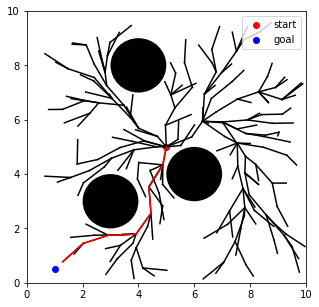

In [12]:
fig, ax = plt.subplots(figsize=[5,5])
rrtstar.show()
plt.legend(loc='upper right');

# make snapshot for visualization
anim.set_snapshot(num=20);

### Visualization 

In [13]:
anim.make_gif('out_rrtstar.gif')

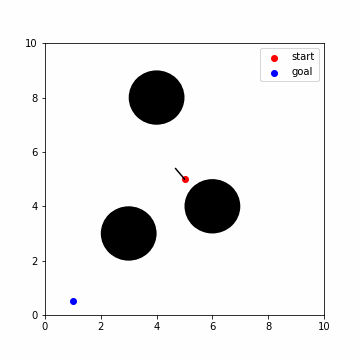

In [14]:
from IPython.display import Image
Image(filename="out_rrtstar.gif")